<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")



dolfin version: 2019.1.0


[0.002282331125093801, 0.004564662250187602, 0.009620419043952212, 0.014676175837716823, 0.019731932631481434, 0.02835626637019461, 0.0463933698184414, 0.06443047326668819, 0.08246757671493499, 0.11070207556565316, 0.13893657441637133, 0.16717107326708952, 0.1954055721178077, 0.2236400709685259, 0.25187456981924405, 0.2801090686699622, 0.3083435675206804, 0.35699766876184846, 0.40565177000301655, 0.45430587124418464, 0.5029599724853527, 0.5975833138319654, 0.692206655178578, 0.7868299965251907, 0.8814533378718034, 0.976076679218416, 1.0707000205650286, 1.1653233619116412, 1.2599467032582539, 1.3545700446048665, 1.4491933859514792, 1.5438167272980918, 1.6384400686447045, 1.7330634099913171, 1.8940874236267151, 2.055111437262113]


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


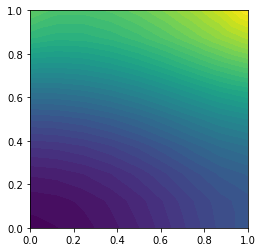

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


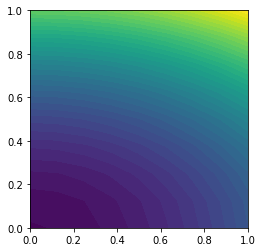

In [78]:
"""
FEniCS tutorial demo program: Diffusion of a Gaussian hill.

  u'= Laplace(u) + f  in a square domain
  u = u_D             on the boundary
  u = u_0             at t = 0

  u_D = f = 0

The initial condition u_0 is chosen as a Gaussian hill.
"""
from scipy.integrate import ode

from __future__ import print_function
from fenics import *
import time

'''
T = 1.0            # final time
num_steps = 1     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
                 degree=2, a=5)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - u_n*v*dx

K = assemble(dot(grad(u), grad(v))*dx)
'''

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Function(V)
fc = beta - 2 - 2*alpha
f.vector()[:] = fc

K = assemble(dot(grad(u), grad(v))*dx)
M = assemble(u*v*dx)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(beta), boundary)


def dydt(t, u):
    rhs = Function(V)
    rhs.vector()[:] = (-1)*K*u + M*f.vector()
    #ue = Function(V)
    # bc.apply(rhs.vector())
    #bc.apply(ue.vector())
    #solve(M, ue.vector(), rhs.vector())
    return (rhs.vector());

def jac(t, u):
    return (-1*K).array();

t0 = 0  
solver = ode(dydt, jac).set_integrator('vode', method='bdf', order=15, with_jacobian=True)
solver.set_initial_value(u_n.vector(), t0)

t_out=[]
while solver.successful() and solver.t < T:
    solver.integrate(solver.t+dt, step=True)
    t_out.append(solver.t)
    # print("%g" % r.t); 
    # print(r.y)
    # print("%g %g" % (r.t, r.y))
    
print(t_out)    
u=Function(V);    
u.vector()[:]=solver.y[:];
plot(u)

u_D.t = T;
ue = project(u_D, V);
plt.figure();
plot(ue)


References

https://stackoverflow.com/questions/12926393/using-adaptive-step-sizes-with-scipy-integrate-ode

